 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><ul class="toc-item"><ul class="toc-item"><ul class="toc-item"><li><span><a href="https://localhost:8889/notebooks/FindKeyRiverScalingMonthly.ipynb#fig,-ax-=-plt.subplots(1,-1,-figsize=(18,-4))" data-toc-modified-id="fig,-ax-=-plt.subplots(1,-1,-figsize=(18,-4))-0.0.0.1"><span class="toc-item-num">0.0.0.1&nbsp;&nbsp;</span>fig, ax = plt.subplots(1, 1, figsize=(18, 4))</a></span></li></ul></ul></ul></ul></div>

This is monthly, previous notebook was looking at yearly

In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = (31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)

Note, I call the rivers Squamish but I am doing all of them with this notebook

In [680]:
squamish1 = pd.read_csv('Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
squamish2 = pd.read_csv('Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
squamish3 = pd.read_csv('Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
watershed = 'Toba'

In [681]:
for squamish in [squamish1, squamish2, squamish3]:
    length = squamish.year.shape[0]
    dates = []
    for i in range(length):
        dates.append(datetime.datetime(squamish.year[i], squamish.month[i], squamish.day[i]))
    squamish['dates'] = dates
squamish1 = squamish1.set_index('dates')
squamish2 = squamish2.set_index('dates')
squamish3 = squamish3.set_index('dates')
squamish = squamish1 + squamish3 - squamish2

In [112]:
secondary = pd.read_csv('Capilano_intake_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
usesecondary = True

In [113]:
squamish = pd.read_csv('river_flows/Squamish_Brackendale_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
watershed = 'Howe'

In [114]:
length = squamish.year.shape[0]
dates = []
for i in range(length):
    dates.append(datetime.datetime(squamish.year[i], squamish.month[i], squamish.day[i]))
squamish['dates'] = dates
squamish = squamish.set_index('dates')
print(squamish[:5])

            year  month  day   flow
dates                              
1922-11-24  1922     11   24   51.3
1922-11-25  1922     11   25  115.0
1922-11-26  1922     11   26  279.0
1922-11-27  1922     11   27  331.0
1922-11-28  1922     11   28  360.0


In [115]:
if usesecondary:
    length = secondary.year.shape[0]
    dates = []
    for i in range(length):
        dates.append(datetime.datetime(secondary.year[i], secondary.month[i], secondary.day[i]))
    secondary['dates'] = dates
    secondary = secondary.set_index('dates')
secondary[:5]

,year,month,day,flow
dates,,,,
1914-01-01,1914,1,1,44.5
1914-01-02,1914,1,2,68.5
1914-01-03,1914,1,3,75.0
1914-01-04,1914,1,4,236.0
1914-01-05,1914,1,5,195.0


In [116]:
diffy = squamish.index[1:] - squamish.index[:-1]
diffy_data = pd.DataFrame({'date': squamish.index[1:],
                           'year' : squamish.year[1:],
                        'gap' : diffy[:]})
diffy_data = diffy_data.set_index('date')

if usesecondary:
    diffy2 = secondary.index[1:] - secondary.index[:-1]
    diffy2_data = pd.DataFrame({'date' : secondary.index[1:],
                              'year' : secondary.year[1:],
                              'gap' : diffy2[:]})
    diffy2_data = diffy2_data.set_index('date')

In [117]:
goodyears = []
minyear = 1970
for year in range(minyear, 2010):
    maxgap = diffy_data.gap[diffy_data.year == year].max()
    if usesecondary and maxgap == maxgap:
        maxgap = max(maxgap, diffy2_data.gap[diffy2_data.year == year].max())
    if maxgap == datetime.datetime(1980, 1, 2) - datetime.datetime(1980, 1, 1):
        if squamish.flow[squamish.year == year].shape[0] >= 365:
            if not np.isnan(squamish.flow[squamish.year == year].mean(skipna=False)):
                if usesecondary:
                    if secondary.flow[secondary.year == year].shape[0] >= 365:
                        if not np.isnan(secondary.flow[secondary.year == year].mean(skipna=False)):
                            goodyears.append(year)
                else:
                    goodyears.append(year)

In [118]:
print (goodyears)

[1970, 1971, 1977, 1979, 1980, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]


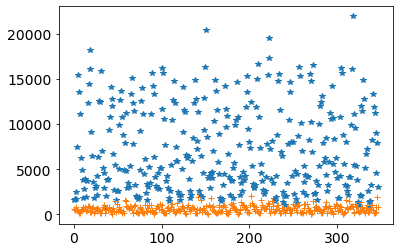

In [119]:
squamish_flux = np.zeros(12*len(goodyears))
squamish_daily = np.zeros(365*len(goodyears))
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        squamish_flux[i*12 + j] = (squamish.flow[(squamish.year == year) & (squamish.month==j+1)].mean() *
                                   days_in_month[j])
        if squamish_flux[i*12 + j] != squamish_flux[i*12 + j]:
            print (year, month)
    squamish_daily[i*365: (i+1)*365] = squamish.flow[(squamish.year == year)][0:365]
plt.plot(squamish_flux, '*');

if usesecondary:
    secondary_flux = np.zeros(12*len(goodyears))
    secondary_daily = np.zeros(365*len(goodyears))
    for i, year in enumerate(goodyears):
        for j, month in enumerate(months):
            secondary_flux[i*12 + j] = (secondary.flow[(secondary.year == year) & (secondary.month==j+1)].mean() *
                                   days_in_month[j])
            if secondary_flux[i*12 + j] != secondary_flux[i*12 + j]:
                print (year, month, ' secondary', secondary_flux[i*12+j])
        secondary_daily[i*365: (i+1)*365] = secondary.flow[(secondary.year == year)][0:365]
    plt.plot(secondary_flux, '+');

<ipython-input-120-0609ebc9a052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  squamish[squamish.year < 2010][squamish.year >= lyear]['flow'].plot(ax=ax)
<ipython-input-120-0609ebc9a052>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  squamish[squamish.year < 2010][squamish.year >= lyear]['flow'].resample(
<ipython-input-120-0609ebc9a052>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  secondary[secondary.year < 2010][secondary.year >= lyear]['flow'].plot(ax=ax)
<ipython-input-120-0609ebc9a052>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  secondary[secondary.year < 2010][secondary.year >= lyear]['flow'].resample(


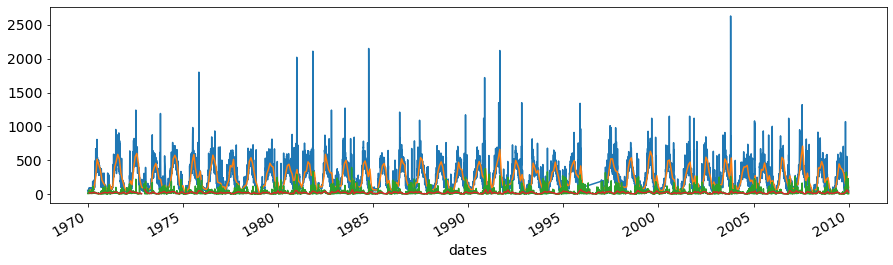

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
lyear = 1970
squamish[squamish.year < 2010][squamish.year >= lyear]['flow'].plot(ax=ax)
squamish[squamish.year < 2010][squamish.year >= lyear]['flow'].resample(
    'm').mean().plot(ax=ax)
if usesecondary:
    secondary[secondary.year < 2010][secondary.year >= lyear]['flow'].plot(ax=ax)
    secondary[secondary.year < 2010][secondary.year >= lyear]['flow'].resample(
    'm').mean().plot(ax=ax)

0.692637324333191
0.723586559295654
0.709363043308258
0.848915040493012
1.35644233226776
2.47054362297058
2.20354437828064
1.53245401382446
1.04729378223419
1.35383641719818
1.20993959903717
0.978208959102631


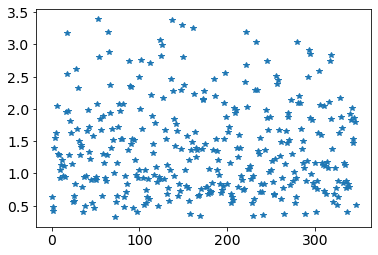

In [121]:
howe_flux = np.zeros(12*len(goodyears))
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'], engine='openpyxl')
        howe_flux[i*12 +j] = morrison[month][morrison['Water Year'] == watershed]
        if year == 1994:
            print (howe_flux[i*12 + j])
plt.plot(howe_flux, '*');

Howe
0.774770319461823
Howe
0.800687670707703
Howe
0.835203230381012
Howe
1.19422554969788
Howe
2.33045148849487
Howe
2.7122974395752
Howe
2.55979537963867
Howe
1.89330756664276
Howe
1.29397618770599
Howe
1.37095391750336
Howe
1.28300738334656
Howe
1.01652979850769


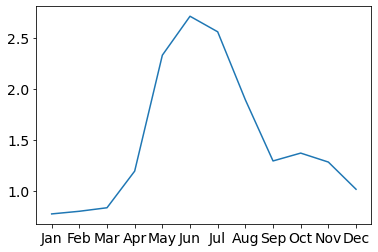

In [122]:
climate = np.zeros(12)
for j, month in enumerate(months):
    print (watershed)
    morrison2 = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name='Normal',
                             names = ['Water Year', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec', 'Junk'], engine='openpyxl')
    climate[j] = morrison2[month][morrison2.index == watershed]
    print (climate[j])
plt.plot(months, climate);

In [123]:
morrison2

,Water Year,area,total,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Junk
Columbia,Column1,685292.000000,211.410000,20.290000,18.080000,19.300000,26.760000,23.970000,22.460000,15.430000,12.110000,9.630000,10.550000,13.890000,18.950000,NaN
Fraser,NaN,235396.003181,111.944478,4.677457,3.908139,4.425884,6.617468,15.517584,21.252230,17.681072,11.542284,7.686703,6.750496,6.720601,5.164561,0.823984
Nass,NaN,55242.343828,100.710600,5.981985,5.101757,4.850020,6.667318,10.945331,13.133337,10.032291,7.717140,7.868610,11.842194,8.871496,7.699121,NaN
Stikine,NaN,75670.000847,95.197118,6.050361,5.410818,4.840972,4.507800,7.009562,9.892276,9.666977,8.272748,11.529243,11.495540,7.980250,8.540571,NaN
Caamano,NaN,30857.719360,78.185262,5.428343,3.894779,3.896798,5.021444,7.101933,8.106097,7.649526,6.156513,6.792955,9.594662,7.900700,6.641513,NaN
WVI,NaN,16932.120239,52.634166,6.255283,5.022522,4.418494,4.182978,4.655321,4.027434,2.691702,1.807035,2.004359,4.127758,6.633032,6.808249,NaN
Skeena,NaN,56272.000671,49.296749,1.435487,1.104727,1.143953,2.319817,8.236003,11.265835,7.141410,3.955770,3.405269,4.416167,2.929732,1.942581,NaN
Hakai,NaN,32516.159851,47.508506,2.648836,1.891646,1.831015,2.333735,4.788220,6.578314,6.352093,5.517066,4.475223,4.497941,3.457951,3.136466,NaN
Knight,NaN,19436.999981,36.792139,1.679822,0.878393,1.337789,1.832101,3.603825,5.180463,5.937473,5.311687,3.843059,3.157359,2.417451,1.612718,NaN
WC,NaN,15881.999512,33.320165,5.243871,3.781510,3.524299,2.541869,1.961753,1.477248,0.934686,0.659940,0.839207,2.229037,4.748279,5.378468,NaN


2468226.0753078815
483.8282482326031
2.268780822062716
483.8282482326032
10.465334788237401
20.227350376823843
24.40725050172741


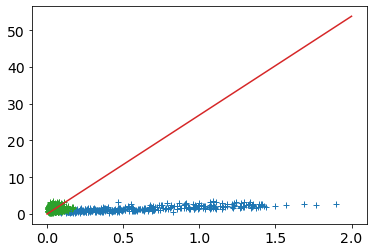

In [124]:
plt.plot(squamish_flux*86400/1e9, howe_flux, '+');
print (squamish_flux.sum())
print (howe_flux.sum())
slope = howe_flux.sum()/(squamish_flux.sum()*86400/1e9)
print (slope)
plt.plot([0, 0.1], [0, 0.1*slope])
weight_prediction = slope*(squamish_flux*86400/1e9)
print (weight_prediction.sum())
print (np.sqrt(((weight_prediction-howe_flux)**2).sum()))

if usesecondary:
    plt.plot(secondary_flux*86400/1e9, howe_flux, '+');
    slope2 = howe_flux.sum()/(secondary_flux.sum()*86400/1e9)
    plt.plot([0, 2], [0, 2*slope2])
    weight_prediction2 = slope2*(secondary_flux*86400/1e9)
    print (np.sqrt(((weight_prediction2-howe_flux)**2).sum()))
    print (np.sqrt(((weight_prediction2-weight_prediction)**2).sum()))


In [18]:
model = LinearRegression(fit_intercept=True)

model.fit(squamish_flux[:, np.newaxis]*86400/1e9, howe_flux)

xfit = np.linspace(0, 0.1, 10)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(squamish_flux*86400/1e9, howe_flux)
plt.plot(xfit, yfit, 'r');
print (model.predict(squamish_flux[:, np.newaxis]*86400/1e9).sum())
print (howe_flux.sum())
print (model.coef_, model.intercept_)
linear_slope = model.coef_
linear_intercept = model.intercept_
linear_predictions =model.predict(squamish_flux[:, np.newaxis]*86400/1e9)

NameError: name 'LinearRegression' is not defined

0.3377588254889061
426.39439986844025
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              2707.
Date:                Sat, 27 Jul 2024   Prob (F-statistic):                   5.91e-166
Time:                        15:13:21   Log-Likelihood:                         -269.60
No. Observations:                 348   AIC:                                      541.2
Df Residuals:                     347   BIC:                                      545.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

array([1.99946043])

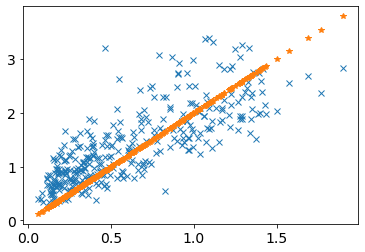

In [125]:
X = squamish_flux*86400/1e9
y = howe_flux

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

plt.plot(X, y, 'x')
plt.plot(X, predictions,'*')
# Print out the statistics
print ((np.sqrt(((predictions-y)**2).sum()))/len(goodyears))
print(predictions.sum())
print (model.summary())
upit = howe_flux.sum()/predictions.sum()
print (upit, upit*model.params)
model.params

0.270725791208111
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     603.2
Date:                Sat, 27 Jul 2024   Prob (F-statistic):           8.85e-79
Time:                        14:39:23   Log-Likelihood:                -205.36
No. Observations:                 360   AIC:                             414.7
Df Residuals:                     358   BIC:                             422.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5455      0.041  

array([0.54553647, 1.38263585])

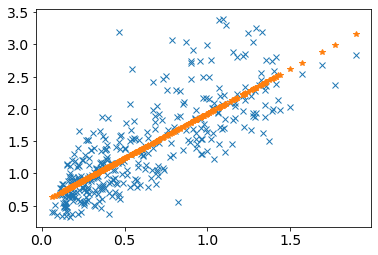

In [20]:
x = squamish_flux*86400/1e9
X = x
X = sm.add_constant(X)
y = howe_flux

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions2 = model.predict(X)
plt.plot(x, y, 'x')
plt.plot(x, predictions2,'*')
# Print out the statistics
print ((np.sqrt(((predictions2-y)**2).sum()))/len(goodyears))
print(model.summary())
model.params

0.232 0.185551677812
0.233 0.185551649595
0.234 0.185551649959

0.29040588145122725
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              1887.
Date:                Sat, 27 Jul 2024   Prob (F-statistic):                   7.73e-187
Time:                        15:13:29   Log-Likelihood:                         -217.03
No. Observations:                 348   AIC:                                      438.1
Df Residuals:                     346   BIC:                                      445.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

array([1.65288744, 6.02986041])

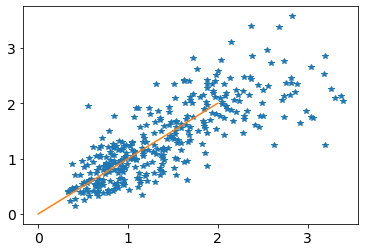

In [126]:
# Standard Version
x = squamish_flux*86400/1e9
x2 = secondary_flux*86400/1e9
X = np.column_stack((x, x2))
#X = sm.add_constant(X)
y = howe_flux

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions4 = model.predict(X)
#plt.plot(x, y, 'x')
plt.plot(y, predictions4,'*')
plt.plot ([0, 2], [0, 2], '-')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions4.sum())
print (howe_flux.sum())
upit = howe_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params


coeffs

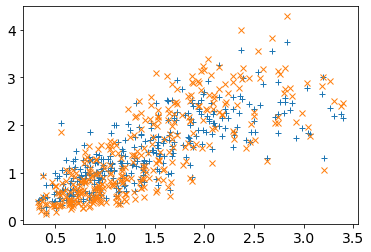

In [130]:
plt.plot(y, predictions4*1.05, '+')
plt.plot(y, predictions*1.13, 'x')

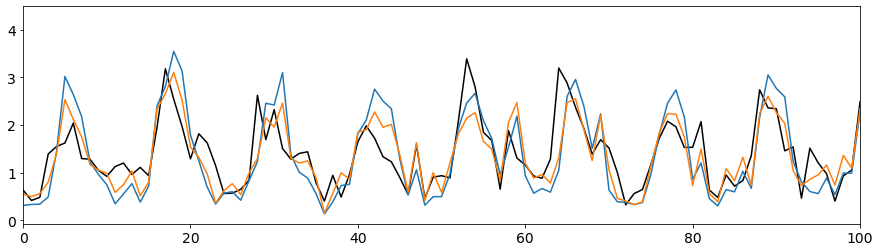

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(y, 'k')
ax.plot(predictions*1.13)
ax.plot(predictions4*1.05)
ax.set_xlim(0, 100);
# Orange, that is the new model including Capilano at the intake,
# is better than the Squamish Alone

77.94140257870336
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              996.9
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                   1.80e-101
Time:                        11:24:28   Log-Likelihood:                         -1136.4
No. Observations:                 192   AIC:                                      2277.
Df Residuals:                     190   BIC:                                      2283.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

array([  8.13779386, 129.63487875])

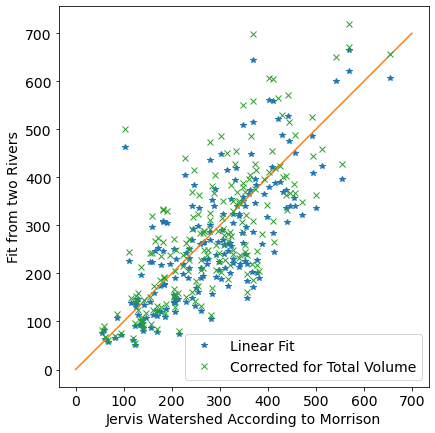

In [131]:
# For Talk, change units, not as good as not taking into account the length of the months

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
x = squamish_flux/30.5 #*86400/1e9
x2 = secondary_flux/30.5 #*86400/1e9
X = np.column_stack((x, x2))
#X = sm.add_constant(X)
y = howe_flux/86400*1e9/30.5

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions4 = model.predict(X)
#plt.plot(x, y, 'x')
ax.plot(y, predictions4,'*', label='Linear Fit')

ax.plot ([0, 700], [0, 700], '-')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions4.sum())
print (howe_flux.sum())
upit = howe_flux.sum()/86400*1e9/30.5/predictions4.sum()
ax.plot(y, predictions4*upit, 'x', label="Corrected for Total Volume")
coeffs = model.params
ax.set_aspect('equal')
ax.set_xlabel("Jervis Watershed According to Morrison")
ax.set_ylabel("Fit from two Rivers")
ax.legend()
plt.savefig('fit.png', dpi=150)
coeffs

0.06 0.188429733902
0.07 0.187142663881
0.077 0.186869763956
0.078 0.186862723836
0.079 0.186862648103
0.08  0.186869233174
0.083 0.186926112261
0.085 0.186992337482
0.09 0.187243342386
0.095 0.187596497167
0.1  0.188030978995
0.12 0.190287497497
0.14 0.192933188799
0.15 0.194294037563
0.16 0.195648948532
0.17 0.196983887632
0.18 0.19828960825
0.19 0.199560203113
0.20 0.200792103727
0.21 0.20198338205
0.22 0.20313325895

In [ ]:
x = squamish_flux*86400/1e9
X = x/(0.079+x)
#X = sm.add_constant(X)
y = howe_flux - x

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions5 = model.predict(X)
plt.plot(x, y+x, 'x')
plt.plot(x, predictions5+x,'*')
plt.plot(x, predictions4, 'o')
# Print out the statistics
print ((np.sqrt(((predictions5-y)**2).sum()))/len(goodyears))
print(model.summary())
model.params

0.37754194315
0.834040046503 1


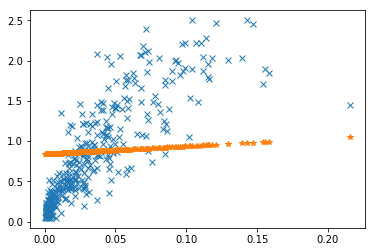

In [723]:
X = squamish_flux*86400/1e9
b = howe_flux.mean() - X.mean()
predictions3 = b + X

# Fit and make the predictions by the model
plt.plot(x, y, 'x')
plt.plot(x, predictions3,'*')
# Print out the statistics
print ((np.sqrt(((predictions3-y)**2).sum()))/len(goodyears))
print (b, '1')

In [724]:
k = int(howe_flux.shape[0]/10)
idx = np.argpartition(howe_flux, k)
idz = np.argpartition(howe_flux, -k)
hf_low = howe_flux[idx[:k]].sum()
hf_high = howe_flux[idz[-k:]].sum()
idx = np.argpartition(weight_prediction, k)
idz = np.argpartition(weight_prediction, -k)
wp_low = weight_prediction[idx[:k]].sum()
wp_high = weight_prediction[idz[-k:]].sum()
idx = np.argpartition(linear_predictions, k)
idz = np.argpartition(linear_predictions, -k)
lp_low = linear_predictions[idx[:k]].sum()
lp_high = linear_predictions[idz[-k:]].sum()
# alpha * wp + (1 - alpha) * lp) = hf
# alpha (wp-lp) + lp = hf
alpha_low = (hf_low - lp_low)/(wp_low - lp_low)
alpha_high = (hf_high - lp_high)/(wp_high - lp_high)
print (alpha_low, alpha_high)
alpha = 0.5 * (alpha_low+alpha_high)
print (alpha)
mixed_predictions = alpha*weight_prediction + (1-alpha)*linear_predictions

0.801461359328 0.0693378414462
0.435399600387


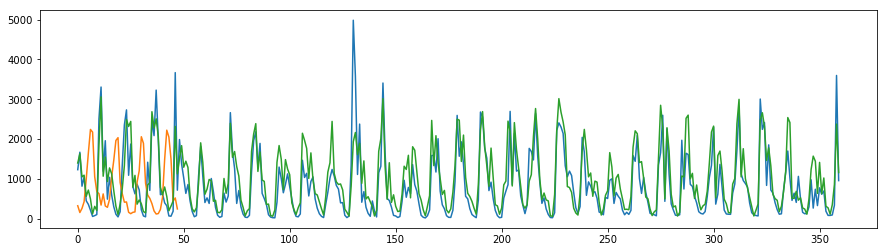

In [725]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(squamish_flux*2)
plt.plot(secondary_flux/10.)
plt.plot(howe_flux*1e9/86400/10);

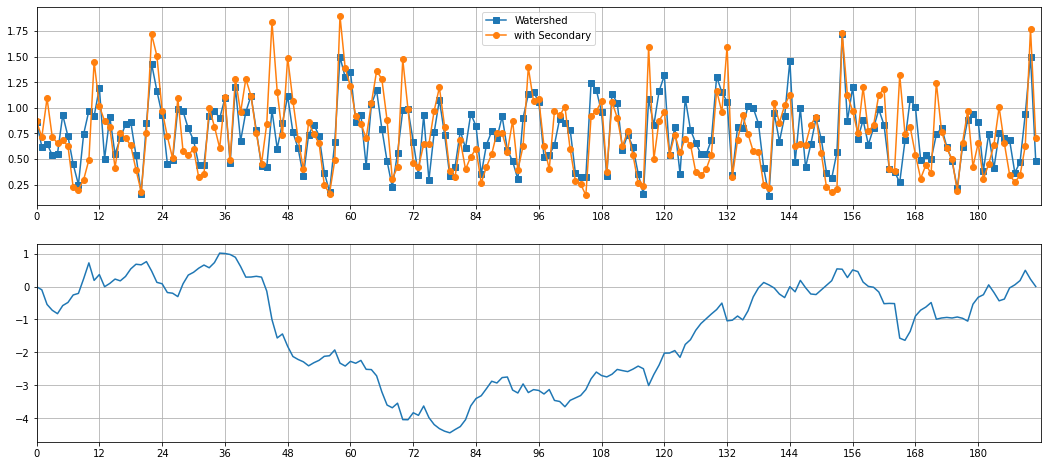

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(18, 8))
#axs[0].plot(weight_prediction2, '<-', label='weight secondary')
#plt.plot(linear_predictions,'+-', label='linear')
#plt.plot(mixed_predictions, 'o-', label='mixed')
#plt.plot(predictions2,'x-', label="with const")
axs[0].plot(howe_flux, 's-', label='Watershed')
#plt.plot(predictions3,'*-', label="1x and const")
axs[0].plot(predictions4*upit,'o-', label="with Secondary")
#plt.plot(predictions5+x,'^-', label="1x Menton")
axs[0].legend()
axs[1].plot(np.cumsum(howe_flux - predictions4*upit))
#axs[1].plot(np.cumsum(howe_flux - weight_prediction2))
#axs[1].plot(np.cumsum(howe_flux - predictions4*upit))
for ax in axs:
    ax.set_xticks(range(0, 192, 12))
    ax.grid()
    ax.set_xlim(0, 192);

The mixed does better in the lows and the total is correct for all of these.

[ 154.   86.   53.   25.   20.   14.    2.    5.    0.    0.    1.    0.]
[ 139.   95.   59.   36.   27.    4.    0.    0.    0.    0.    0.    0.]


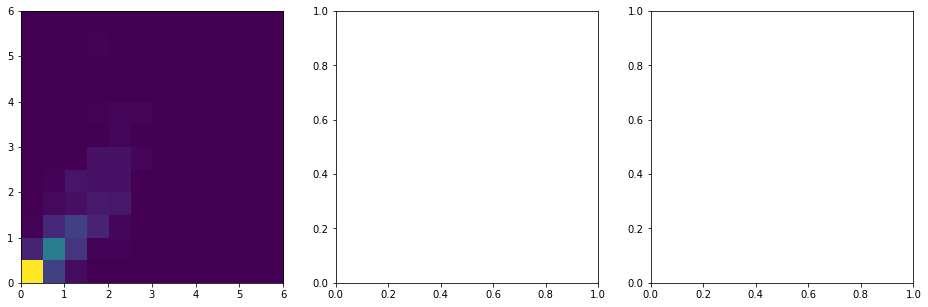

In [732]:
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
print(axs[0].hist2d(howe_flux, weight_prediction, bins=bins)[0].sum(axis=0));
#print(axs[1].hist2d(howe_flux, weight_prediction2, bins=bins)[0].sum(axis=0));
#print(axs[2].hist2d(howe_flux, (predictions4*upit), bins=bins)[0].sum(axis=0))
print(axs[0].hist2d(howe_flux, weight_prediction, bins=bins)[0].sum(axis=1))

In [733]:
myslope = alpha * slope + (1-alpha) * linear_slope
myintercept = ((1 - alpha) * linear_intercept / (365/12.))*1e9/86400
print (myintercept, myslope, slope)

64.3361494253 [ 19.81965516] 24.6047828461


(0, 4000)

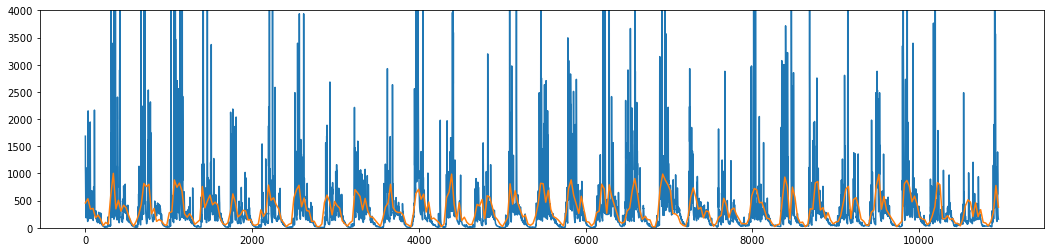

In [736]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
xx = squamish_daily
xy = secondary_daily

#plt.plot(range(len(xx)), slope2 * xy)
#plt.plot(range(len(xx)),  (coeffs[0]*xx +  coeffs[1]*xy)*upit)
plt.plot(range(len(xx)), slope * xx)
plt.plot(np.arange(0, 30.5*len(mixed_predictions), 30.5), howe_flux/30.5*1e9/86400, label='Morrison')
plt.ylim(0, 4000)

In [21]:
print((coeffs[0]*upit, coeffs[1]*upit))

(8.80988124160506, 140.34121604293424)


In [ ]:
### Homathko_Mouth for Bute.  Multiply by 2.015 or (61.17 + 1.785 x)
### Clowhom_ClowhomLake and Roberts_Roberts for Jervis. 8.810*Clowhom + 140.3*Roberts
### Squamish_Brackendale for Howe. Multiply by 2.276 or (89.00 + 1.893 x)
### SanJuan_PortRenfrew for JdF. Multiply by 8.501 or (32.837 + 7.801 x)
### Salmon_Sayward for EVI_N, Multiply by 10.334 or (152.15 + 7.859 x)
### Englishman for EVI_S, 24.60*Englishman   # looked at other rivers, but they are similar
### Theodosia and Homathko for Toba, 14.58*Theodosia + 0.4563*Homathko
### Skagit and Snohomish for Skagit, 1.267*Skagit + 1.236*Snohomish
### Nisqually and Greenwater for Puget, 8.790*Nisqually + 29.09*Greenwater

In [ ]:
bute_flux = np.zeros((2010-1970+1, 12))
for i, year in enumerate(range(1970, 2010+1)):
    morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheetname=str(year))
    bute_flux[i, :] = morrison[morrison['Water Year'] == watershed].iloc[:, 4:16]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
for i in range(12):
    ax.plot(np.arange(1970, 2010+1)+i/12.+1/12., bute_flux[:, i], '*');
monthly = squamish['flow'].resample('1M').mean()
ax.plot(monthly.index.year + (monthly.index.month)/12., monthly*30.5*86400/1e9*2, 'x-')
ax.set_xlim(2000, 2010)

In [93]:
start = datetime.datetime(1994, 1, 15)
end = datetime.datetime(2009, 12, 15)
months = []
for month in arrow.Arrow.range('month', start, end):
    months.append(month.datetime)

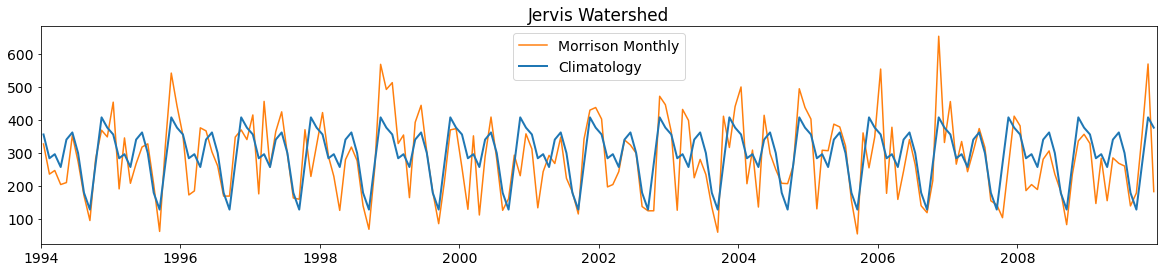

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
lyear = 1994
#squamish.flow.plot(ax=ax, alpha=0.2)
#if usesecondary:
#    secondary.flow.plot(ax=ax, alpha=0.2)
ax.plot(months, howe_flux/30.5*1e9/86400, label='Morrison Monthly', color='tab:orange')
ax.plot(months, np.stack([climate]*16).flatten()/30.5*1e9/86400,label='Climatology', linewidth=2, color='tab:blue')
#(coeffs[0] * upit * squamish.flow + coeffs[1] * upit * secondary.flow).plot(ax=ax, alpha=0.5)
ax.set_xlim(datetime.datetime(1994, 1, 1), datetime.datetime(2009, 12, 31));
ax.legend();
ax.set_title("Jervis Watershed")
plt.savefig('operational_rivers.png', dpi=150)

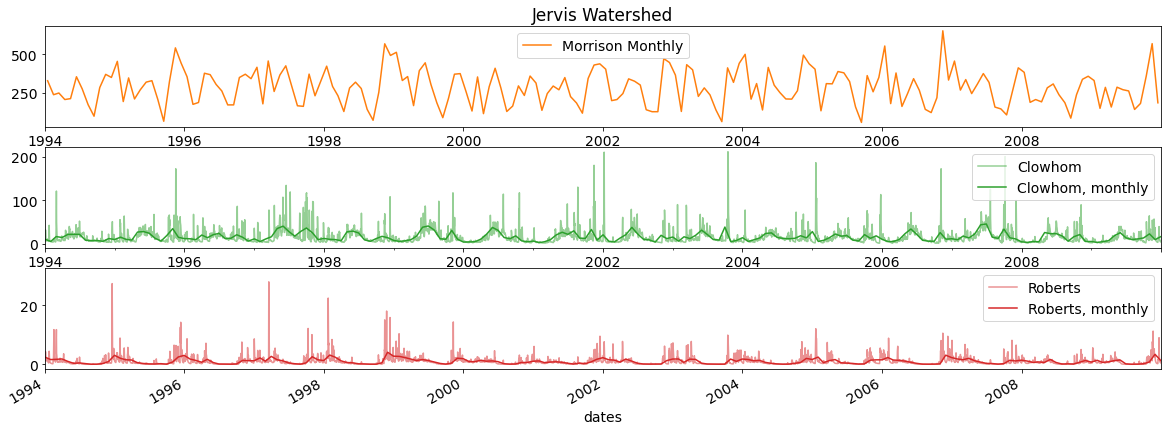

In [116]:
fig, axs = plt.subplots(3, 1, figsize=(20, 7))
lyear = 1994
squamish.flow.plot(ax=axs[1], alpha=0.5, color='tab:green', label="Clowhom")
squamish.flow.resample(
    'm').mean().plot(ax=axs[1], color='tab:green',label="Clowhom, monthly")
if usesecondary:
    secondary.flow.plot(ax=axs[2], alpha=0.5, color='tab:red', label='Roberts')
    secondary.flow.resample('m').mean().plot(ax=axs[2], color='tab:red', label='Roberts, monthly')
axs[0].plot(months, howe_flux/30.5*1e9/86400, label='Morrison Monthly', color='tab:orange')
#ax.plot(months, np.stack([climate]*16).flatten()/30.5*1e9/86400,label='Climatology', linewidth=2, color='tab:blue')
#(coeffs[0] * upit * squamish.flow + coeffs[1] * upit * secondary.flow).plot(ax=ax, alpha=0.5)
for ax in axs:
    ax.set_xlim(datetime.datetime(1994, 1, 1), datetime.datetime(2009, 12, 31));
    ax.legend();
axs[0].set_title("Jervis Watershed")
plt.savefig('candidate_rivers.png', dpi=150)

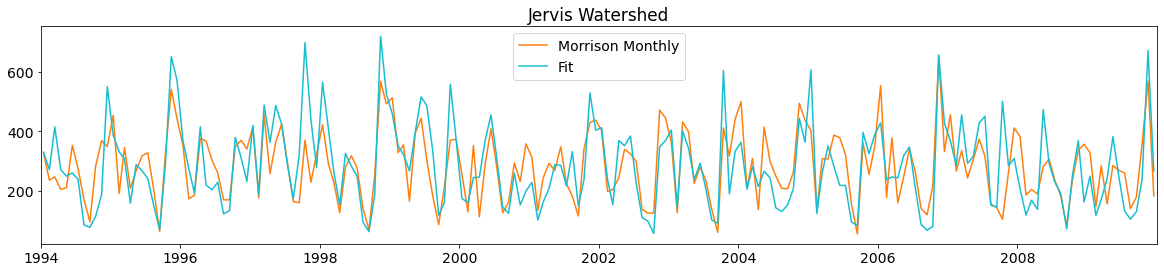

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
lyear = 1994
#squamish.flow.plot(ax=ax, alpha=0.2)
#if usesecondary:
#    secondary.flow.plot(ax=ax, alpha=0.2)
ax.plot(months, howe_flux/30.5*1e9/86400, label='Morrison Monthly', color='tab:orange')
#ax.plot(months, np.stack([climate]*16).flatten()/30.5*1e9/86400,label='Climatology', linewidth=2, color='tab:blue')
ax.plot(months, (coeffs[0] * upit * squamish_flux + coeffs[1] * upit * secondary_flux)/30.5,
        color='tab:cyan', label='Fit')
ax.set_xlim(datetime.datetime(1994, 1, 1), datetime.datetime(2009, 12, 31));
ax.legend();
ax.set_title("Jervis Watershed")
plt.savefig('timeseries_fit.png', dpi=150)

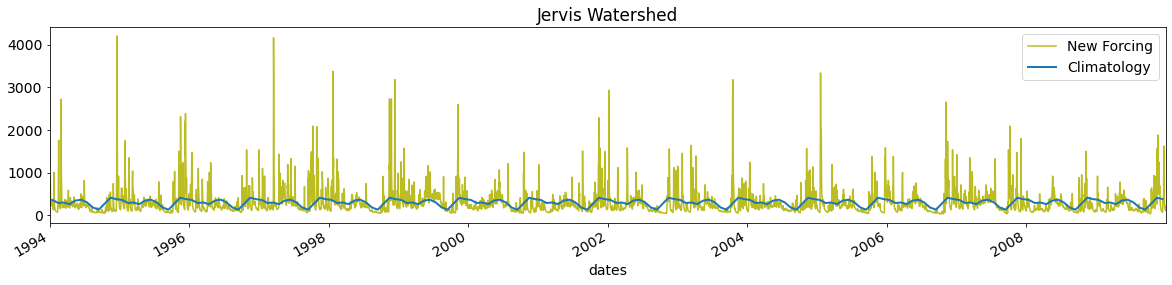

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
lyear = 1994
#squamish.flow.plot(ax=ax, alpha=0.2)
#if usesecondary:
#    secondary.flow.plot(ax=ax, alpha=0.2)
#ax.plot(months, howe_flux/30.5*1e9/86400, label='Morrison Monthly', color='tab:orange')
(coeffs[0] * upit * squamish.flow + coeffs[1] * upit * secondary.flow).plot(ax=ax, color='tab:olive', label='New Forcing')
ax.plot(months, np.stack([climate]*16).flatten()/30.5*1e9/86400,label='Climatology', linewidth=2, color='tab:blue')
ax.set_xlim(datetime.datetime(1994, 1, 1), datetime.datetime(2009, 12, 31));
ax.legend();
ax.set_title("Jervis Watershed")
plt.savefig('NetChange.png', dpi=150)

In [127]:
(0.34-0.29)/1/(0.29/2)

0.3448275862068969